In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def grad(t, Q, v, p , A, b):
  return t*((Q.T+Q).dot(v)+p) + np.sum((1/(b-A.dot(v)).T)*A.T, axis=1).reshape(-1,1)

def Hessian(t, Q, v, A, b):
  return 2*t*Q + sum([1/((b-A.dot(v))[i])**2 * A[i,].reshape(-1,1).dot(A[i,].reshape(1,-1)) for i in range(A.shape[0])])

def g(t, Q, v, p , A, b):
  if not ( b - A.dot(v) > 0).all() :
    raise Exception('Error')
  else:
    return t*(v.T@Q@v + p.T.dot(v)) - np.sum(np.log(b-A.dot(v)))

def back_line_search(t, Q, v, p , A, b, delta, alpha, beta):
    rate = 1
    while not(((b-A.dot(v + rate * delta))>0).all()) or (g(t, Q, v + rate * delta, p , A, b) > g(t, Q, v, p , A, b) + 
      alpha*rate*grad(t, Q, v, p , A, b).T.dot(delta)):

        rate = beta*rate
    return rate

def centering_step(Q, p, A, b, t, v0, eps):
  alpha = 0.1
  beta = 0.5
  
  v = [v0]
  n_eps = 0
  while True:
    delta = - np.linalg.inv(Hessian(t, Q, v[-1], A, b)).dot(grad(t, Q, v[-1], p , A, b))
    lambda_sq =  - grad(t, Q, v[-1], p , A, b).T.dot(delta)
    if lambda_sq/2 <= eps:
      break
    else:
      n_eps += 1
      rate = back_line_search(t, Q, v[-1], p , A, b, delta, alpha, beta)
      v.append( v[-1] + delta*rate)
  return v, n_eps

In [0]:
def barr_method(Q, p , A, b , v0, eps, mu):   
    t = 1  #to be determined
    m = A.shape[0]
    v = [v0]
    n_iter = [0]
    while 1:
        v0, n_eps = centering_step(Q,p,A,b,t,v[-1],eps)
        v.append(v0[-1])
        n_iter.append(n_iter[-1]+n_eps)
        if m/t < eps:
            break
        else:
            t *= mu
    return v, n_iter

In [0]:
n = 100
d = 15

X = np.random.random_sample(size=(n, d))

w = np.random.random_sample(size=(d,1))
y = X@w + np.random.normal(size=(n,1))

print(X.shape)
print(y.shape)

lambd = 10
Q = (1/2)*np.eye(n)
print(Q)
p = -y
A = np.vstack((X.T,-X.T))
print(A[0,:].shape)
b = lambd*np.ones((2*d,1))
v0 = np.zeros((n,1))
eps = 0.0001

(100, 15)
(100, 1)
[[0.5 0.  0.  ... 0.  0.  0. ]
 [0.  0.5 0.  ... 0.  0.  0. ]
 [0.  0.  0.5 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.5 0.  0. ]
 [0.  0.  0.  ... 0.  0.5 0. ]
 [0.  0.  0.  ... 0.  0.  0.5]]
(100,)


In [0]:
#back_line_search(t, Q, v0, p , A, b, delta, 0.1, 0.5)
barr_method(Q, p , A, b , v0, eps, mu)  

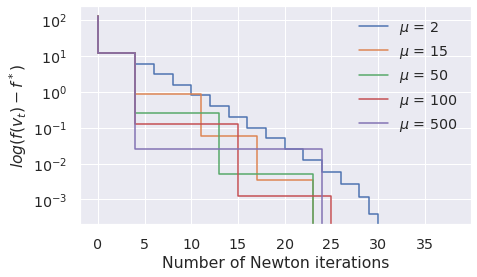

In [0]:
plt.figure(figsize=(7,4)) 

list_w_opt = []

for mu in [2,15,50,100,500]:
    v_seq, n_iter = barr_method(Q,p,A,b,v0,0.001,mu)
    list_w_opt.append(np.reshape(np.linalg.inv(X.T@X)@X.T@(v_seq[-1] + y),d))
    v_last = v_seq[-1]
    gap = [(v0.T@Q@v0 + p.T.dot(v0))[0,0] - (v_last.T@Q@v_last + p.T.dot(v_last))[0,0] for v0 in v_seq]
    plt.step(n_iter, gap, label='$\mu$ = '+str(mu))
plt.legend(loc = 'upper right')
plt.semilogy()
plt.xlabel('Number of Newton iterations')
plt.ylabel('$log (f(v_t)-f^*)$')
plt.savefig("plot1")
plt.show()


[]

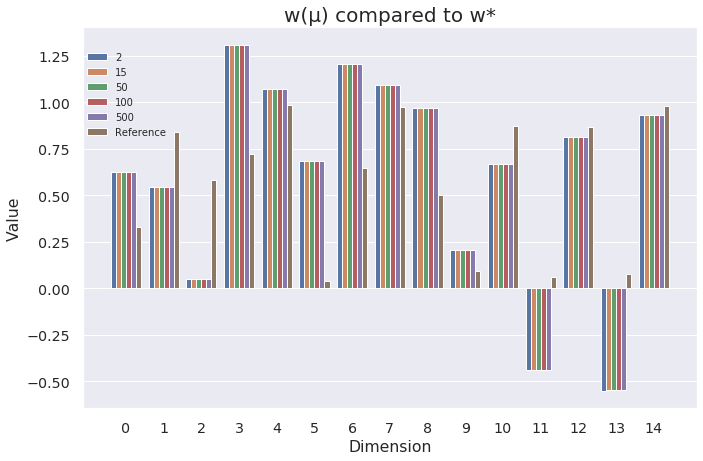

In [0]:
import pandas as pd
import seaborn as sns

plt.style.use('seaborn')

sns.set(font_scale=1.3)

list_mu = [2,15,50,100, 500]

dt = pd.DataFrame({list_mu[i]:list_w_opt[i] for i in range(len(list_mu))})
dt['Reference'] = pd.Series(np.reshape(w,d))
dt['Dimension'] = pd.Series(np.arange(d))
dt = dt.melt(id_vars='Dimension', var_name='Mu', value_name='Value')

plt.figure(figsize=(11, 7))
plt.title('w(µ) compared to w*', size = 20)
sns.barplot(data=dt, hue='Mu', y='Value', x='Dimension')
plt.legend(loc=(0, 0.7), prop={'size': 10})
plt.savefig("plot2")
plt.plot()